In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
# import clip
import open_clip
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import os
from uuid import uuid4
from sklearn.model_selection import train_test_split
import warnings
import torchsummary
warnings.filterwarnings("ignore")
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Custom Dataset
class AIGIDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
    def __init__(self, data_df, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to CSV file with image paths, prompts, and MOS scores.
            img_dir (str): Directory containing images.
            transform: Image transformations.
        """
#         self.data = pd.read_csv(csv_file)
        self.data = data_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]["name"])
        image = Image.open(img_name).convert("RGB")
        
        # Initial prompt
        initial_prompt = self.data.iloc[idx]["prompt"]
        
        # MOS score (quality score)
        mos_score = float(self.data.iloc[idx]["mos_quality"])
        # print(mos_score)
        mos_align_score = float(self.data.iloc[idx]["mos_align"])
        if self.transform:
            image = self.transform(image)
        
        return {
            "image": image,
            "initial_prompt": initial_prompt,
            "mos_score": mos_score,
            "mos_score_align": mos_align_score
        }

# Image patch extraction
def extract_patches(image, patch_size=112, stride=56):
    """
    Extract patches from an image.
    Args:
        image (Tensor): Input image [C, H, W].
        patch_size (int): Size of each patch.
        stride (int): Stride for patch extraction.
    Returns:
        List of patches.
    """
    patches = []
#     print(image.shape) (1,3,224,224)
    _, _, h, w = image.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[:,:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    # print(f"Extracted {len(patches)} patches of size {patch_size}x{patch_size} from image.")
    return patches

# Task-specific prompt construction
def construct_task_specific_prompts():
    """
    Construct task-specific prompts for alignment and perception quality.
    Returns:
        Dictionary with alignment and perception prompts.
    """
    alignment_adverbs = ["badly", "poorly", "fairly", "well", "perfectly"]
    perception_adjectives = ["bad", "poor", "fair", "good", "perfect"]
    perception_antonyms = ["bad","good","perfect"]
    
    alignment_prompts = [f"A photo that {adv} matches {{pt}}." for adv in alignment_adverbs]
    perception_prompts_1 = [f"A photo of {adj} quality." for adj in perception_adjectives]
    perception_prompts_2=[f"{ant} photo." for ant in perception_antonyms]
    return {
        "alignment": alignment_prompts,
        "perception_adjective": perception_prompts_1,
        "perception_antonym": perception_prompts_2
        
    }



Using device: cuda


In [45]:
# Main function
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 5e-6
weight_decay = 5e-4
image_size = 224
alpha = 1  # Balance parameter

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                       std=[0.26862954, 0.26130258, 0.27577711])
])

data_df = pd.read_csv(r"AGIQA_3k/data.csv")
print(data_df.columns)
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))


# Load datasets (replace with your paths)
train_dataset = AIGIDataset(
    #csv_file="./AIGIQA-3k/AIGIQA-3k/data.csv",  # Columns: image_name, prompt, mos_score
    data_df = train_df,
    img_dir=r"AGIQA_3k/AGIQA-3K",
    transform=transform
)
test_dataset = AIGIDataset(
    #csv_file="./AIGIQA-3k/AIGIQA-3k/data.csv",
    data_df = test_df,
    img_dir=r"AGIQA_3k/AGIQA-3K",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Load CLIP model
# clip_model, preprocess = clip.load("ViT-B/32", device=device)


# Load CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai", device=device)


Index(['name', 'prompt', 'adj1', 'adj2', 'style', 'mos_quality', 'std_quality',
       'mos_align', 'std_align'],
      dtype='object')
Training samples: 2385
Testing samples: 597


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


class TSPMGS(nn.Module):
    def __init__(self, clip_model, num_quality_levels=5, alpha=0.5):
        super(TSPMGS, self).__init__()
        self.clip_model = clip_model
        self.num_quality_levels = num_quality_levels
        self.alpha = alpha
        self.num_quality_levels_ant = 3

        # Resize transform for patches
        self.patch_resize = transforms.Resize((224, 224))

        # Perceptual quality head
        self.q_predictor_percep = nn.Sequential(
            nn.Linear(3, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Alignment quality head
        self.q_predictor_align = nn.Sequential(
            nn.Linear(3, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, images, patches_list, task_prompts, initial_prompts):
        image_features = self.clip_model.encode_image(images).float()
        if torch.isnan(image_features).any():
            print("NaNs found in patches!")

        patch_features = []

        for batch_patches in patches_list:  # [36, 3, 64, 64]
            resized_patches = torch.stack([self.patch_resize(patch.squeeze(0)) if patch.dim() == 4 else self.patch_resize(patch) for patch in batch_patches])
            with torch.no_grad():
                patch_feats = self.clip_model.encode_image(resized_patches).float()  # [N, D]
            patch_feats = patch_feats.mean(dim=0)  # Mean over patches

            patch_features.append(patch_feats)

        patch_features = torch.stack(patch_features).float()

        align_prompt_feats = self.clip_model.encode_text(task_prompts["alignment"]).float()
        percep_prompt_feats = self.clip_model.encode_text(task_prompts["perception_adjective"]).float()
        percep_antonym_prompt_feats = self.clip_model.encode_text(task_prompts["perception_antonym"]).float()

        initial_tokens = open_clip.tokenize(initial_prompts).to(images.device)
        with torch.no_grad():
            word_features = self.clip_model.encode_text(initial_tokens)
            word_mask = (initial_tokens != 0).float()

        def compute_coarse_similarity(img_feats, txt_feats):
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            similarities = img_feats @ txt_feats.T
            temperature = 0.07
            probs = torch.softmax(similarities / temperature, dim=-1)
            return probs, similarities

        align_img_probs_adv, _ = compute_coarse_similarity(image_features, align_prompt_feats)
        align_patch_probs_adv, _ = compute_coarse_similarity(patch_features, align_prompt_feats)

        percep_img_probs, _ = compute_coarse_similarity(image_features, percep_prompt_feats)
        percep_patch_probs, _ = compute_coarse_similarity(patch_features, percep_prompt_feats)

        percep_img_probs_antonym, _ = compute_coarse_similarity(image_features, percep_antonym_prompt_feats)
        percep_patch_probs_antonym, _ = compute_coarse_similarity(patch_features, percep_antonym_prompt_feats)

        def compute_fine_similarity(img_feats, prompt_feats):
            img_feats = F.normalize(img_feats, dim=-1)
            prompt_feats = F.normalize(prompt_feats, dim=-1)
            return (img_feats * prompt_feats).sum(dim=1)


        img_word_sim = compute_fine_similarity(image_features, word_features)
        patch_word_sim = compute_fine_similarity(patch_features.squeeze(1), word_features)

        def compute_quality_score(probs, num_levels):
            quality_levels = torch.arange(1, num_levels + 1, device=probs.device).float()
            score = (num_levels / (num_levels - 1)) * ((probs * quality_levels).sum(dim=-1) - 1)
            return score

        # Coarse-grained scores
        Q_cg_I_align = compute_quality_score(align_img_probs_adv, self.num_quality_levels)
        Q_cg_P_align = compute_quality_score(align_patch_probs_adv, self.num_quality_levels)

        Q_cg_I_percep = compute_quality_score(percep_img_probs, self.num_quality_levels)
        Q_cg_P_percep = compute_quality_score(percep_patch_probs, self.num_quality_levels)

        Q_cg_I_percep_ant = compute_quality_score(percep_img_probs_antonym, self.num_quality_levels_ant)
        Q_cg_P_percep_ant = compute_quality_score(percep_patch_probs_antonym, self.num_quality_levels_ant)

        Q_cg_I = (Q_cg_I_percep + Q_cg_I_percep_ant) / 2
        Q_cg_P = (Q_cg_P_percep + Q_cg_P_percep_ant) / 2
        Q_fg_adj = ((img_word_sim + patch_word_sim) / 2) * self.num_quality_levels
        Q_fg_ant = ((img_word_sim + patch_word_sim) / 2) * self.num_quality_levels_ant
        Q_fg = (Q_fg_adj + Q_fg_ant) / 2

        q_input_percep = torch.stack([Q_cg_I, Q_cg_P, Q_fg], dim=-1)  # [B, 3]
        q_input_align = torch.stack([Q_cg_I_align, Q_cg_P_align, Q_fg], dim=-1)

        # Perceptual prediction head
        Q_percep = self.q_predictor_percep(q_input_percep).squeeze(1)
        Q_percep = torch.clamp(Q_percep, 0.0, 5.0)

        # Alignment prediction head
        Q_align = self.q_predictor_align(q_input_align).squeeze(1)
        Q_align = torch.clamp(Q_align, 0.0, 5.0)

        return Q_percep, Q_align
# # Initialize TSP-MGS model
model = TSPMGS(clip_model, num_quality_levels=5, alpha=alpha).to(device)
# Model summary
# torchsummary.summary(model, [(3, 224, 224), (36, 3, 64, 64), 
#                              {"alignment_adverb": (5,), "perception_adjective": (5,), "perception_antonym": (3,)}], 
#                      device=device.type)

In [47]:
# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-7)
from transformers import get_cosine_schedule_with_warmup

num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Loss function
criterion = nn.L1Loss()  # MAE as per paper
# criterion = nn.MSELoss()  # Faster convergence in practice

# Construct task-specific prompts
task_prompt_templates = construct_task_specific_prompts()
# Tokenize task-specific prompts
task_prompts = {
    "alignment": open_clip.tokenize(task_prompt_templates["alignment"]).to(device),
    "perception_adjective": open_clip.tokenize(task_prompt_templates["perception_adjective"]).to(device),
    "perception_antonym": open_clip.tokenize(task_prompt_templates["perception_antonym"]).to(device)
}

In [ ]:
from tqdm import tqdm

# Hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 3e-4  
weight_decay = 5e-4
image_size = 224
alpha = 0.5  # Weight for perceptual loss (1 - alpha is for alignment)

# Training function with tqdm
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, task_prompts):
    """
    Train the TSP-MGS model with multi-head output (perception and alignment).
    """
    model.train()
    train_loss = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()
            mos_scores_align = batch["mos_score_align"].to(device).float()

            # Extract patches
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l])

            patches_list = patches_tensor.to(device)

            optimizer.zero_grad()

            # Forward pass: get perceptual and alignment predictions
            outputs_percep, outputs_align = model(images, patches_list, task_prompts, initial_prompts)

            # Compute losses
            loss_percep = criterion(outputs_percep, mos_scores)
            loss_align = criterion(outputs_align, mos_scores_align)
            loss = alpha * loss_percep + (1 - alpha) * loss_align

            # Backward and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        print(f"Percep Loss: {loss_percep.item():.4f}, Align Loss: {loss_align.item():.4f}")
        train_loss.append(epoch_loss)

        # Save model checkpoint
        torch.save(model.state_dict(), "tsp_mgs_model.pth")

        # Step learning rate scheduler
        scheduler.step()

    torch.save(model.state_dict(), "tsp_mgs_model_overall.pth")
    print("Model saved as tsp_mgs_model_overall.pth")
    return train_loss,model

In [49]:
# Train model
print("Starting training...")
train_loss,trained_model=train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, task_prompts)

Starting training...

Epoch [1/200]


Epoch [1/200], Loss: 2.4978
Percep Loss: 2.7230, Align Loss: 2.6468

Epoch [2/200]


Epoch [2/200], Loss: 2.4982
Percep Loss: 2.4275, Align Loss: 2.3049

Epoch [3/200]


Epoch [3/200], Loss: 2.4966
Percep Loss: 2.1847, Align Loss: 2.3072

Epoch [4/200]


Epoch [4/200], Loss: 2.4938
Percep Loss: 2.6882, Align Loss: 2.3859

Epoch [5/200]


Epoch [5/200], Loss: 2.4927
Percep Loss: 2.4743, Align Loss: 2.6187

Epoch [6/200]


Epoch [6/200], Loss: 2.4910
Percep Loss: 2.4665, Align Loss: 2.6576

Epoch [7/200]


Epoch [7/200], Loss: 2.4900
Percep Loss: 2.8311, Align Loss: 2.9392

Epoch [8/200]


Epoch [8/200], Loss: 2.4894
Percep Loss: 2.4087, Align Loss: 2.2823

Epoch [9/200]


Epoch [9/200], Loss: 2.4888
Percep Loss: 2.4001, Align Loss: 2.5650

Epoch [10/200]


Epoch [10/200], Loss: 2.4872
Percep Loss: 2.5041, Align Loss: 2.6105

Epoch [11/200]


Epoch [11/200], Loss: 2.4860
Percep Loss: 2.4291, Align Loss: 2.5554

Epoch [12/200]


Epoch [12/200], Loss: 2.4721
Percep Loss: 2.3494, Align Loss: 2.5243

Epoch [13/200]


Epoch [13/200], Loss: 2.4551
Percep Loss: 2.3717, Align Loss: 2.2914

Epoch [14/200]


Epoch [14/200], Loss: 2.4492
Percep Loss: 2.3543, Align Loss: 2.5538

Epoch [15/200]


Epoch [15/200], Loss: 2.4437
Percep Loss: 2.1286, Align Loss: 2.2365

Epoch [16/200]


Epoch [16/200], Loss: 2.4389
Percep Loss: 2.4461, Align Loss: 2.1578

Epoch [17/200]


Epoch [17/200], Loss: 2.4330
Percep Loss: 2.1533, Align Loss: 2.0415

Epoch [18/200]


Epoch [18/200], Loss: 2.4281
Percep Loss: 2.5608, Align Loss: 2.4657

Epoch [19/200]


Epoch [19/200], Loss: 2.4226
Percep Loss: 2.6429, Align Loss: 2.5418

Epoch [20/200]


Epoch [20/200], Loss: 2.4165
Percep Loss: 2.7398, Align Loss: 2.8508

Epoch [21/200]


Epoch [21/200], Loss: 2.4084
Percep Loss: 2.3894, Align Loss: 2.3374

Epoch [22/200]


Epoch [22/200], Loss: 2.4024
Percep Loss: 2.3287, Align Loss: 2.4186

Epoch [23/200]


Epoch [23/200], Loss: 2.3951
Percep Loss: 2.5915, Align Loss: 2.3491

Epoch [24/200]


Epoch [24/200], Loss: 2.3866
Percep Loss: 2.6021, Align Loss: 2.3800

Epoch [25/200]


Epoch [25/200], Loss: 2.3804
Percep Loss: 2.6250, Align Loss: 2.6235

Epoch [26/200]


Epoch [26/200], Loss: 2.3703
Percep Loss: 2.4523, Align Loss: 2.4649

Epoch [27/200]


Epoch [27/200], Loss: 2.3631
Percep Loss: 2.3793, Align Loss: 2.2458

Epoch [28/200]


Epoch [28/200], Loss: 2.3529
Percep Loss: 2.3474, Align Loss: 2.1386

Epoch [29/200]


Epoch [29/200], Loss: 2.3436
Percep Loss: 2.4703, Align Loss: 2.2807

Epoch [30/200]


Epoch [30/200], Loss: 2.3347
Percep Loss: 2.5701, Align Loss: 2.3492

Epoch [31/200]


Epoch [31/200], Loss: 2.3238
Percep Loss: 2.4663, Align Loss: 2.4898

Epoch [32/200]


Epoch [32/200], Loss: 2.3125
Percep Loss: 2.2405, Align Loss: 2.2129

Epoch [33/200]


Epoch [33/200], Loss: 2.3042
Percep Loss: 2.0702, Align Loss: 1.8578

Epoch [34/200]


Epoch [34/200], Loss: 2.2899
Percep Loss: 2.5669, Align Loss: 2.5974

Epoch [35/200]


Epoch [35/200], Loss: 2.2781
Percep Loss: 1.8838, Align Loss: 1.9479

Epoch [36/200]


Epoch [36/200], Loss: 2.2654
Percep Loss: 2.1895, Align Loss: 2.1065

Epoch [37/200]


Epoch [37/200], Loss: 2.2533
Percep Loss: 2.1116, Align Loss: 2.3156

Epoch [38/200]


Epoch [38/200], Loss: 2.2394
Percep Loss: 2.2486, Align Loss: 2.1055

Epoch [39/200]


Epoch [39/200], Loss: 2.2232
Percep Loss: 2.6167, Align Loss: 2.5778

Epoch [40/200]


Epoch [40/200], Loss: 2.2097
Percep Loss: 2.2290, Align Loss: 2.0708

Epoch [41/200]


Epoch [41/200], Loss: 2.1936
Percep Loss: 2.0143, Align Loss: 1.8868

Epoch [42/200]


Epoch [42/200], Loss: 2.1765
Percep Loss: 2.0536, Align Loss: 2.1755

Epoch [43/200]


Epoch [43/200], Loss: 2.1582
Percep Loss: 2.1557, Align Loss: 2.2478

Epoch [44/200]


Epoch [44/200], Loss: 2.1373
Percep Loss: 2.4420, Align Loss: 2.3170

Epoch [45/200]


Epoch [45/200], Loss: 2.1182
Percep Loss: 2.3773, Align Loss: 2.3571

Epoch [46/200]


Epoch [46/200], Loss: 2.0982
Percep Loss: 2.1153, Align Loss: 2.4815

Epoch [47/200]


Epoch [47/200], Loss: 2.0737
Percep Loss: 2.2410, Align Loss: 2.0923

Epoch [48/200]


Epoch [48/200], Loss: 2.0486
Percep Loss: 2.2609, Align Loss: 2.0692

Epoch [49/200]


Epoch [49/200], Loss: 2.0254
Percep Loss: 2.3053, Align Loss: 2.1606

Epoch [50/200]


Epoch [50/200], Loss: 1.9980
Percep Loss: 2.1034, Align Loss: 2.3299

Epoch [51/200]


Epoch [51/200], Loss: 1.9652
Percep Loss: 2.0833, Align Loss: 2.3460

Epoch [52/200]


Epoch [52/200], Loss: 1.9364
Percep Loss: 1.8882, Align Loss: 1.7620

Epoch [53/200]


Epoch [53/200], Loss: 1.9070
Percep Loss: 1.9158, Align Loss: 1.9765

Epoch [54/200]


Epoch [54/200], Loss: 1.8742
Percep Loss: 1.8972, Align Loss: 2.1224

Epoch [55/200]


Epoch [55/200], Loss: 1.8381
Percep Loss: 1.6921, Align Loss: 1.9604

Epoch [56/200]


Epoch [56/200], Loss: 1.8062
Percep Loss: 1.5792, Align Loss: 1.9512

Epoch [57/200]


Epoch [57/200], Loss: 1.7664
Percep Loss: 1.6321, Align Loss: 1.6885

Epoch [58/200]


Epoch [58/200], Loss: 1.7322
Percep Loss: 1.9878, Align Loss: 1.7003

Epoch [59/200]


Epoch [59/200], Loss: 1.6940
Percep Loss: 1.5368, Align Loss: 1.5951

Epoch [60/200]


Epoch [60/200], Loss: 1.6590
Percep Loss: 1.5606, Align Loss: 1.7668

Epoch [61/200]


Epoch [61/200], Loss: 1.6216
Percep Loss: 1.9282, Align Loss: 1.8010

Epoch [62/200]


Epoch [62/200], Loss: 1.5768
Percep Loss: 1.9045, Align Loss: 1.8206

Epoch [63/200]


Epoch [63/200], Loss: 1.5457
Percep Loss: 1.2344, Align Loss: 1.3976

Epoch [64/200]


Epoch [64/200], Loss: 1.5035
Percep Loss: 1.5807, Align Loss: 1.5555

Epoch [65/200]


Epoch [65/200], Loss: 1.4596
Percep Loss: 1.8200, Align Loss: 1.7739

Epoch [66/200]


Epoch [66/200], Loss: 1.4227
Percep Loss: 1.2477, Align Loss: 1.6475

Epoch [67/200]


Epoch [67/200], Loss: 1.3848
Percep Loss: 1.6133, Align Loss: 1.5943

Epoch [68/200]


Epoch [68/200], Loss: 1.3384
Percep Loss: 0.9840, Align Loss: 1.2805

Epoch [69/200]


Epoch [69/200], Loss: 1.3028
Percep Loss: 1.0121, Align Loss: 1.1985

Epoch [70/200]


Epoch [70/200], Loss: 1.2612
Percep Loss: 1.2741, Align Loss: 1.4407

Epoch [71/200]


Epoch [71/200], Loss: 1.2204
Percep Loss: 1.2630, Align Loss: 1.2980

Epoch [72/200]


Epoch [72/200], Loss: 1.1761
Percep Loss: 1.3144, Align Loss: 1.1008

Epoch [73/200]


Epoch [73/200], Loss: 1.1278
Percep Loss: 1.3468, Align Loss: 1.3083

Epoch [74/200]


Epoch [74/200], Loss: 1.0967
Percep Loss: 1.0527, Align Loss: 1.2251

Epoch [75/200]


Epoch [75/200], Loss: 1.0592
Percep Loss: 1.0776, Align Loss: 1.0420

Epoch [76/200]


Epoch [76/200], Loss: 1.0255
Percep Loss: 0.9736, Align Loss: 1.2691

Epoch [77/200]


Epoch [77/200], Loss: 0.9917
Percep Loss: 0.6414, Align Loss: 0.9632

Epoch [78/200]


Epoch [78/200], Loss: 0.9618
Percep Loss: 0.5288, Align Loss: 1.1168

Epoch [79/200]


Epoch [79/200], Loss: 0.9366
Percep Loss: 0.8323, Align Loss: 1.0101

Epoch [80/200]


Epoch [80/200], Loss: 0.9102
Percep Loss: 0.8076, Align Loss: 0.9218

Epoch [81/200]


Epoch [81/200], Loss: 0.8933
Percep Loss: 0.6973, Align Loss: 0.7928

Epoch [82/200]


Epoch [82/200], Loss: 0.8869
Percep Loss: 0.7700, Align Loss: 0.8708

Epoch [83/200]


Epoch [83/200], Loss: 0.8685
Percep Loss: 1.0883, Align Loss: 0.9171

Epoch [84/200]


Epoch [84/200], Loss: 0.8638
Percep Loss: 0.9909, Align Loss: 1.0871

Epoch [85/200]


Epoch [85/200], Loss: 0.8460
Percep Loss: 0.7054, Align Loss: 0.7420

Epoch [86/200]


Epoch [86/200], Loss: 0.8479
Percep Loss: 0.6268, Align Loss: 0.9392

Epoch [87/200]


Epoch [87/200], Loss: 0.8471
Percep Loss: 0.6875, Align Loss: 0.8191

Epoch [88/200]


Epoch [88/200], Loss: 0.8462
Percep Loss: 1.0793, Align Loss: 0.9096

Epoch [89/200]


Epoch [89/200], Loss: 0.8382
Percep Loss: 1.0815, Align Loss: 0.8199

Epoch [90/200]


Epoch [90/200], Loss: 0.8143
Percep Loss: 0.8453, Align Loss: 0.7321

Epoch [91/200]


Epoch [91/200], Loss: 0.8187
Percep Loss: 0.7575, Align Loss: 0.8321

Epoch [92/200]


Epoch [92/200], Loss: 0.8131
Percep Loss: 0.5665, Align Loss: 1.0029

Epoch [93/200]


Epoch [93/200], Loss: 0.8098
Percep Loss: 0.8592, Align Loss: 0.8565

Epoch [94/200]


Epoch [94/200], Loss: 0.7867
Percep Loss: 1.0631, Align Loss: 1.0244

Epoch [95/200]


Epoch [95/200], Loss: 0.7872
Percep Loss: 0.8868, Align Loss: 0.9756

Epoch [96/200]


Epoch [96/200], Loss: 0.7792
Percep Loss: 0.8034, Align Loss: 0.8405

Epoch [97/200]


Epoch [97/200], Loss: 0.7600
Percep Loss: 0.8199, Align Loss: 0.6735

Epoch [98/200]


Epoch [98/200], Loss: 0.7523
Percep Loss: 0.8494, Align Loss: 0.7884

Epoch [99/200]


Epoch [99/200], Loss: 0.8111
Percep Loss: 0.8706, Align Loss: 0.9744

Epoch [100/200]


Epoch [100/200], Loss: 0.7926
Percep Loss: 0.6581, Align Loss: 0.6837

Epoch [101/200]


Epoch [101/200], Loss: 0.7828
Percep Loss: 0.5336, Align Loss: 0.6741

Epoch [102/200]


Epoch [102/200], Loss: 0.7516
Percep Loss: 0.6326, Align Loss: 0.7571

Epoch [103/200]


Epoch [103/200], Loss: 0.7713
Percep Loss: 0.6519, Align Loss: 0.5134

Epoch [104/200]


Epoch [104/200], Loss: 0.7699
Percep Loss: 0.9610, Align Loss: 0.7924

Epoch [105/200]


Epoch [105/200], Loss: 0.7528
Percep Loss: 0.9067, Align Loss: 0.7780

Epoch [106/200]


Epoch [106/200], Loss: 0.7446
Percep Loss: 0.6209, Align Loss: 0.7683

Epoch [107/200]


Epoch [107/200], Loss: 0.7421
Percep Loss: 0.8115, Align Loss: 0.7048

Epoch [108/200]


Epoch [108/200], Loss: 0.7282
Percep Loss: 0.8397, Align Loss: 0.8496

Epoch [109/200]


Epoch [109/200], Loss: 0.7328
Percep Loss: 0.7555, Align Loss: 0.6433

Epoch [110/200]


Epoch [110/200], Loss: 0.7097
Percep Loss: 0.5410, Align Loss: 0.7096

Epoch [111/200]


Epoch [111/200], Loss: 0.7271
Percep Loss: 0.7832, Align Loss: 0.7529

Epoch [112/200]


Epoch [112/200], Loss: 0.7116
Percep Loss: 0.7995, Align Loss: 0.7245

Epoch [113/200]


Epoch [113/200], Loss: 0.7153
Percep Loss: 0.6108, Align Loss: 0.6209

Epoch [114/200]


Epoch [114/200], Loss: 0.7061
Percep Loss: 0.8242, Align Loss: 0.6045

Epoch [115/200]


Epoch [115/200], Loss: 0.7023
Percep Loss: 0.7502, Align Loss: 0.7545

Epoch [116/200]


Epoch [116/200], Loss: 0.6899
Percep Loss: 0.6390, Align Loss: 0.8981

Epoch [117/200]


Epoch [117/200], Loss: 0.6795
Percep Loss: 0.5671, Align Loss: 0.6160

Epoch [118/200]


Epoch [118/200], Loss: 0.6727
Percep Loss: 0.9156, Align Loss: 0.8957

Epoch [119/200]


Epoch [119/200], Loss: 0.6545
Percep Loss: 0.4906, Align Loss: 0.6836

Epoch [120/200]


Epoch [120/200], Loss: 0.6760
Percep Loss: 0.4513, Align Loss: 0.5187

Epoch [121/200]


Epoch [121/200], Loss: 0.6701
Percep Loss: 0.6676, Align Loss: 0.6752

Epoch [122/200]


Epoch [122/200], Loss: 0.6478
Percep Loss: 0.5141, Align Loss: 0.7952

Epoch [123/200]


Epoch [123/200], Loss: 0.6531
Percep Loss: 0.5574, Align Loss: 0.5272

Epoch [124/200]


Epoch [124/200], Loss: 0.6489
Percep Loss: 0.6038, Align Loss: 0.6402

Epoch [125/200]


Epoch [125/200], Loss: 0.6398
Percep Loss: 0.5922, Align Loss: 0.3943

Epoch [126/200]


Epoch [126/200], Loss: 0.6412
Percep Loss: 0.7506, Align Loss: 0.6837

Epoch [127/200]


Epoch [127/200], Loss: 0.6563
Percep Loss: 0.7104, Align Loss: 0.7870

Epoch [128/200]


Epoch [128/200], Loss: 0.6273
Percep Loss: 0.4283, Align Loss: 0.8158

Epoch [129/200]


Epoch [129/200], Loss: 0.6241
Percep Loss: 0.7021, Align Loss: 0.7570

Epoch [130/200]


Epoch [130/200], Loss: 0.6289
Percep Loss: 0.6774, Align Loss: 0.6103

Epoch [131/200]


Epoch [131/200], Loss: 0.6516
Percep Loss: 0.7770, Align Loss: 0.6434

Epoch [132/200]


Epoch [132/200], Loss: 0.6201
Percep Loss: 0.3788, Align Loss: 0.4991

Epoch [133/200]


Epoch [133/200], Loss: 0.6393
Percep Loss: 0.8871, Align Loss: 0.6559

Epoch [134/200]


Epoch [134/200], Loss: 0.6304
Percep Loss: 0.4360, Align Loss: 0.4158

Epoch [135/200]


Epoch [135/200], Loss: 0.6297
Percep Loss: 0.5077, Align Loss: 0.5084

Epoch [136/200]


Epoch [136/200], Loss: 0.6103
Percep Loss: 0.6852, Align Loss: 1.0041

Epoch [137/200]


Epoch [137/200], Loss: 0.5952
Percep Loss: 0.7047, Align Loss: 0.4752

Epoch [138/200]


Epoch [138/200], Loss: 0.6107
Percep Loss: 0.8768, Align Loss: 0.9569

Epoch [139/200]


Epoch [139/200], Loss: 0.5986
Percep Loss: 0.5094, Align Loss: 0.4601

Epoch [140/200]


Epoch [140/200], Loss: 0.5808
Percep Loss: 0.7493, Align Loss: 1.0073

Epoch [141/200]


Epoch [141/200], Loss: 0.5729
Percep Loss: 0.7004, Align Loss: 0.5249

Epoch [142/200]


Epoch [142/200], Loss: 0.5742
Percep Loss: 0.8558, Align Loss: 0.6911

Epoch [143/200]


Epoch [143/200], Loss: 0.5750
Percep Loss: 0.3832, Align Loss: 0.4455

Epoch [144/200]


Epoch [144/200], Loss: 0.5722
Percep Loss: 0.5764, Align Loss: 0.7061

Epoch [145/200]


Epoch [145/200], Loss: 0.5768
Percep Loss: 0.7503, Align Loss: 0.6942

Epoch [146/200]


Epoch [146/200], Loss: 0.5692
Percep Loss: 0.4827, Align Loss: 0.3987

Epoch [147/200]


Epoch [147/200], Loss: 0.5828
Percep Loss: 0.4393, Align Loss: 0.5000

Epoch [148/200]


Epoch [148/200], Loss: 0.5752
Percep Loss: 0.5795, Align Loss: 0.6398

Epoch [149/200]


Epoch [149/200], Loss: 0.5768
Percep Loss: 0.4807, Align Loss: 0.4564

Epoch [150/200]


Epoch [150/200], Loss: 0.5698
Percep Loss: 0.5963, Align Loss: 0.5579

Epoch [151/200]


Epoch [151/200], Loss: 0.5845
Percep Loss: 0.4930, Align Loss: 0.3835

Epoch [152/200]


Epoch [152/200], Loss: 0.5698
Percep Loss: 0.3809, Align Loss: 0.3300

Epoch [153/200]


Epoch [153/200], Loss: 0.5607
Percep Loss: 0.5178, Align Loss: 0.5842

Epoch [154/200]


Epoch [154/200], Loss: 0.5493
Percep Loss: 0.5229, Align Loss: 0.5056

Epoch [155/200]


Epoch [155/200], Loss: 0.5550
Percep Loss: 0.6374, Align Loss: 0.5037

Epoch [156/200]


Epoch [156/200], Loss: 0.5428
Percep Loss: 0.6763, Align Loss: 0.3924

Epoch [157/200]


Epoch [157/200], Loss: 0.5508
Percep Loss: 0.4180, Align Loss: 0.5380

Epoch [158/200]


Epoch [158/200], Loss: 0.5312
Percep Loss: 0.6106, Align Loss: 0.6655

Epoch [159/200]


Epoch [159/200], Loss: 0.5303
Percep Loss: 0.7303, Align Loss: 0.4859

Epoch [160/200]


Epoch [160/200], Loss: 0.5430
Percep Loss: 0.5541, Align Loss: 0.6887

Epoch [161/200]


Epoch [161/200], Loss: 0.5418
Percep Loss: 0.7127, Align Loss: 0.4108

Epoch [162/200]


Epoch [162/200], Loss: 0.5423
Percep Loss: 0.5220, Align Loss: 0.5850

Epoch [163/200]


Epoch [163/200], Loss: 0.5457
Percep Loss: 0.4087, Align Loss: 0.5598

Epoch [164/200]


Epoch [164/200], Loss: 0.5424
Percep Loss: 0.4882, Align Loss: 0.4904

Epoch [165/200]


Epoch [165/200], Loss: 0.5335
Percep Loss: 0.5955, Align Loss: 0.3994

Epoch [166/200]


Epoch [166/200], Loss: 0.5343
Percep Loss: 0.6076, Align Loss: 0.4271

Epoch [167/200]


Epoch [167/200], Loss: 0.5374
Percep Loss: 0.5038, Align Loss: 0.5498

Epoch [168/200]


Epoch [168/200], Loss: 0.5200
Percep Loss: 0.5130, Align Loss: 0.5745

Epoch [169/200]


Epoch [169/200], Loss: 0.5219
Percep Loss: 0.4414, Align Loss: 0.4369

Epoch [170/200]


Epoch [170/200], Loss: 0.5169
Percep Loss: 0.6278, Align Loss: 0.7365

Epoch [171/200]


Epoch [171/200], Loss: 0.5258
Percep Loss: 0.4341, Align Loss: 0.4294

Epoch [172/200]


Epoch [172/200], Loss: 0.5171
Percep Loss: 0.5826, Align Loss: 0.5815

Epoch [173/200]


Epoch [173/200], Loss: 0.5123
Percep Loss: 0.4440, Align Loss: 0.3506

Epoch [174/200]


Epoch [174/200], Loss: 0.5055
Percep Loss: 0.5855, Align Loss: 0.4085

Epoch [175/200]


Epoch [175/200], Loss: 0.4962
Percep Loss: 0.5014, Align Loss: 0.5169

Epoch [176/200]


Epoch [176/200], Loss: 0.4952
Percep Loss: 0.5847, Align Loss: 0.5246

Epoch [177/200]


Epoch [177/200], Loss: 0.4933
Percep Loss: 0.4637, Align Loss: 0.4964

Epoch [178/200]


Epoch [178/200], Loss: 0.4823
Percep Loss: 0.5234, Align Loss: 0.5669

Epoch [179/200]


Epoch [179/200], Loss: 0.4766
Percep Loss: 0.6838, Align Loss: 0.4661

Epoch [180/200]


Epoch [180/200], Loss: 0.4676
Percep Loss: 0.4267, Align Loss: 0.3654

Epoch [181/200]


Epoch [181/200], Loss: 0.4656
Percep Loss: 0.5904, Align Loss: 0.5005

Epoch [182/200]


Epoch [182/200], Loss: 0.4627
Percep Loss: 0.4177, Align Loss: 0.3998

Epoch [183/200]


Epoch [183/200], Loss: 0.4599
Percep Loss: 0.3318, Align Loss: 0.3451

Epoch [184/200]


Epoch [184/200], Loss: 0.4525
Percep Loss: 0.3699, Align Loss: 0.3847

Epoch [185/200]


Epoch [185/200], Loss: 0.4561
Percep Loss: 0.4128, Align Loss: 0.2937

Epoch [186/200]


Epoch [186/200], Loss: 0.4434
Percep Loss: 0.4319, Align Loss: 0.3740

Epoch [187/200]


Epoch [187/200], Loss: 0.4430
Percep Loss: 0.3834, Align Loss: 0.4262

Epoch [188/200]


Epoch [188/200], Loss: 0.4292
Percep Loss: 0.4839, Align Loss: 0.5241

Epoch [189/200]


Epoch [189/200], Loss: 0.4215
Percep Loss: 0.3528, Align Loss: 0.3257

Epoch [190/200]


Epoch [190/200], Loss: 0.4271
Percep Loss: 0.4988, Align Loss: 0.3048

Epoch [191/200]


Epoch [191/200], Loss: 0.4131
Percep Loss: 0.2879, Align Loss: 0.5223

Epoch [192/200]


Epoch [192/200], Loss: 0.4130
Percep Loss: 0.4438, Align Loss: 0.3975

Epoch [193/200]


Epoch [193/200], Loss: 0.4340
Percep Loss: 0.4030, Align Loss: 0.4109

Epoch [194/200]


Epoch [194/200], Loss: 0.4259
Percep Loss: 0.6224, Align Loss: 0.3991

Epoch [195/200]


Epoch [195/200], Loss: 0.4162
Percep Loss: 0.3351, Align Loss: 0.4443

Epoch [196/200]


Epoch [196/200], Loss: 0.4197
Percep Loss: 0.4187, Align Loss: 0.4003

Epoch [197/200]


Epoch [197/200], Loss: 0.4155
Percep Loss: 0.4725, Align Loss: 0.4766

Epoch [198/200]


Epoch [198/200], Loss: 0.4151
Percep Loss: 0.4341, Align Loss: 0.3182

Epoch [199/200]


Epoch [199/200], Loss: 0.4071
Percep Loss: 0.2833, Align Loss: 0.3341

Epoch [200/200]


Epoch [200/200], Loss: 0.4064
Percep Loss: 0.4163, Align Loss: 0.2508
Model saved as tsp_mgs_model_overall.pth


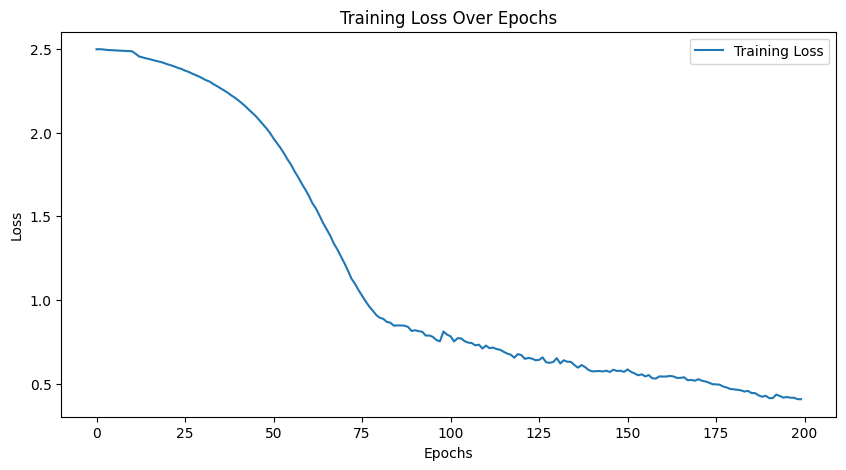

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [51]:
from scipy.stats import spearmanr, pearsonr
import numpy as np
import matplotlib.pyplot as plt

def test_model(model, test_loader, task_prompts):
    model.eval()
    predictions_percep = []
    predictions_align = []
    ground_truths_percep = []
    ground_truths_align = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()
            mos_scores_align = batch["mos_score_align"].to(device).float()

            # Patch extraction
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l]).to(device)

            # Forward pass (multi-head)
            outputs_percep, outputs_align = model(images, patches_tensor, task_prompts, initial_prompts)

            predictions_percep.extend(outputs_percep.view(-1).cpu().numpy())
            predictions_align.extend(outputs_align.view(-1).cpu().numpy())
            ground_truths_percep.extend(mos_scores.view(-1).cpu().numpy())
            ground_truths_align.extend(mos_scores_align.view(-1).cpu().numpy())

    # Convert to numpy arrays
    predictions_percep = np.array(predictions_percep)
    predictions_align = np.array(predictions_align)
    ground_truths_percep = np.array(ground_truths_percep)
    ground_truths_align = np.array(ground_truths_align)

    # Calculate correlations
    srcc_percep = spearmanr(predictions_percep, ground_truths_percep).correlation
    plcc_percep = pearsonr(predictions_percep, ground_truths_percep)[0]

    srcc_align = spearmanr(predictions_align, ground_truths_align).correlation
    plcc_align = pearsonr(predictions_align, ground_truths_align)[0]

    return {
        "perception": {"srcc": srcc_percep, "plcc": plcc_percep,
                       "pred": predictions_percep, "gt": ground_truths_percep},
        "alignment": {"srcc": srcc_align, "plcc": plcc_align,
                      "pred": predictions_align, "gt": ground_truths_align}
    }


Testing the model...


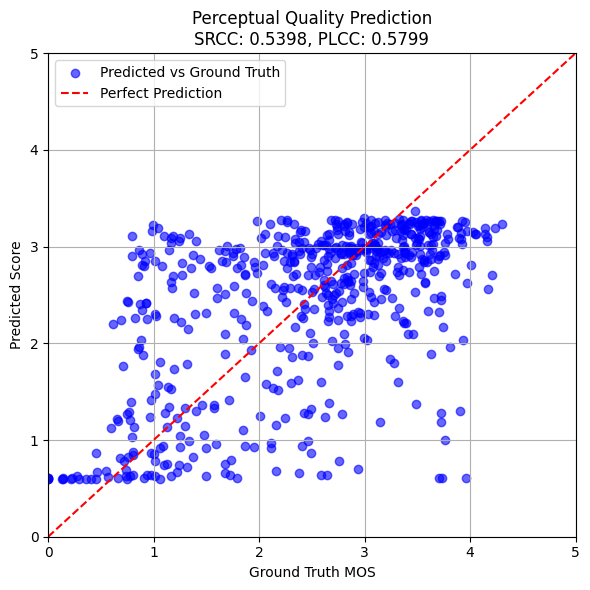

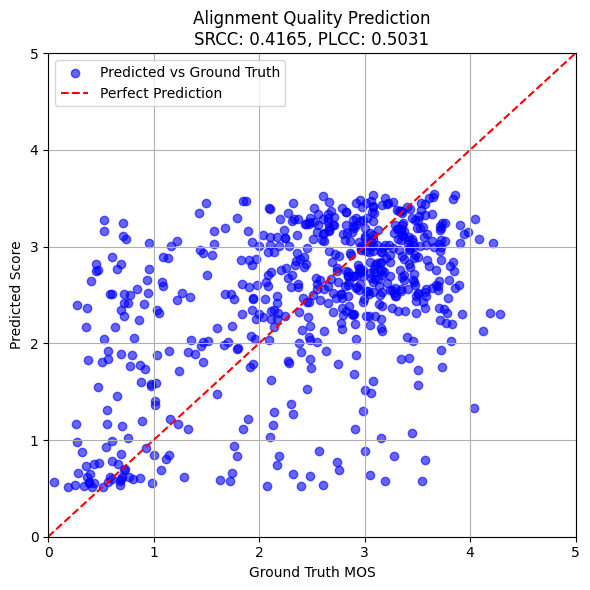

In [52]:
# Test the model
print("Testing the model...")
model = TSPMGS(clip_model, num_quality_levels=5, alpha=alpha).to(device)
model.load_state_dict(torch.load("tsp_mgs_model.pth"))

results = test_model(model, test_loader, task_prompts)

# Plotting function
def plot_results(title, predictions, ground_truths, srcc, plcc):
    plt.figure(figsize=(6, 6))
    plt.scatter(ground_truths, predictions, c='blue', alpha=0.6, label='Predicted vs Ground Truth')
    plt.plot([0, 5], [0, 5], 'r--', label='Perfect Prediction')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('Ground Truth MOS')
    plt.ylabel('Predicted Score')
    plt.title(f'{title}\nSRCC: {srcc:.4f}, PLCC: {plcc:.4f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Perception plot
plot_results("Perceptual Quality Prediction",
             results["perception"]["pred"],
             results["perception"]["gt"],
             results["perception"]["srcc"],
             results["perception"]["plcc"])

# Alignment plot
plot_results("Alignment Quality Prediction",
             results["alignment"]["pred"],
             results["alignment"]["gt"],
             results["alignment"]["srcc"],
             results["alignment"]["plcc"])


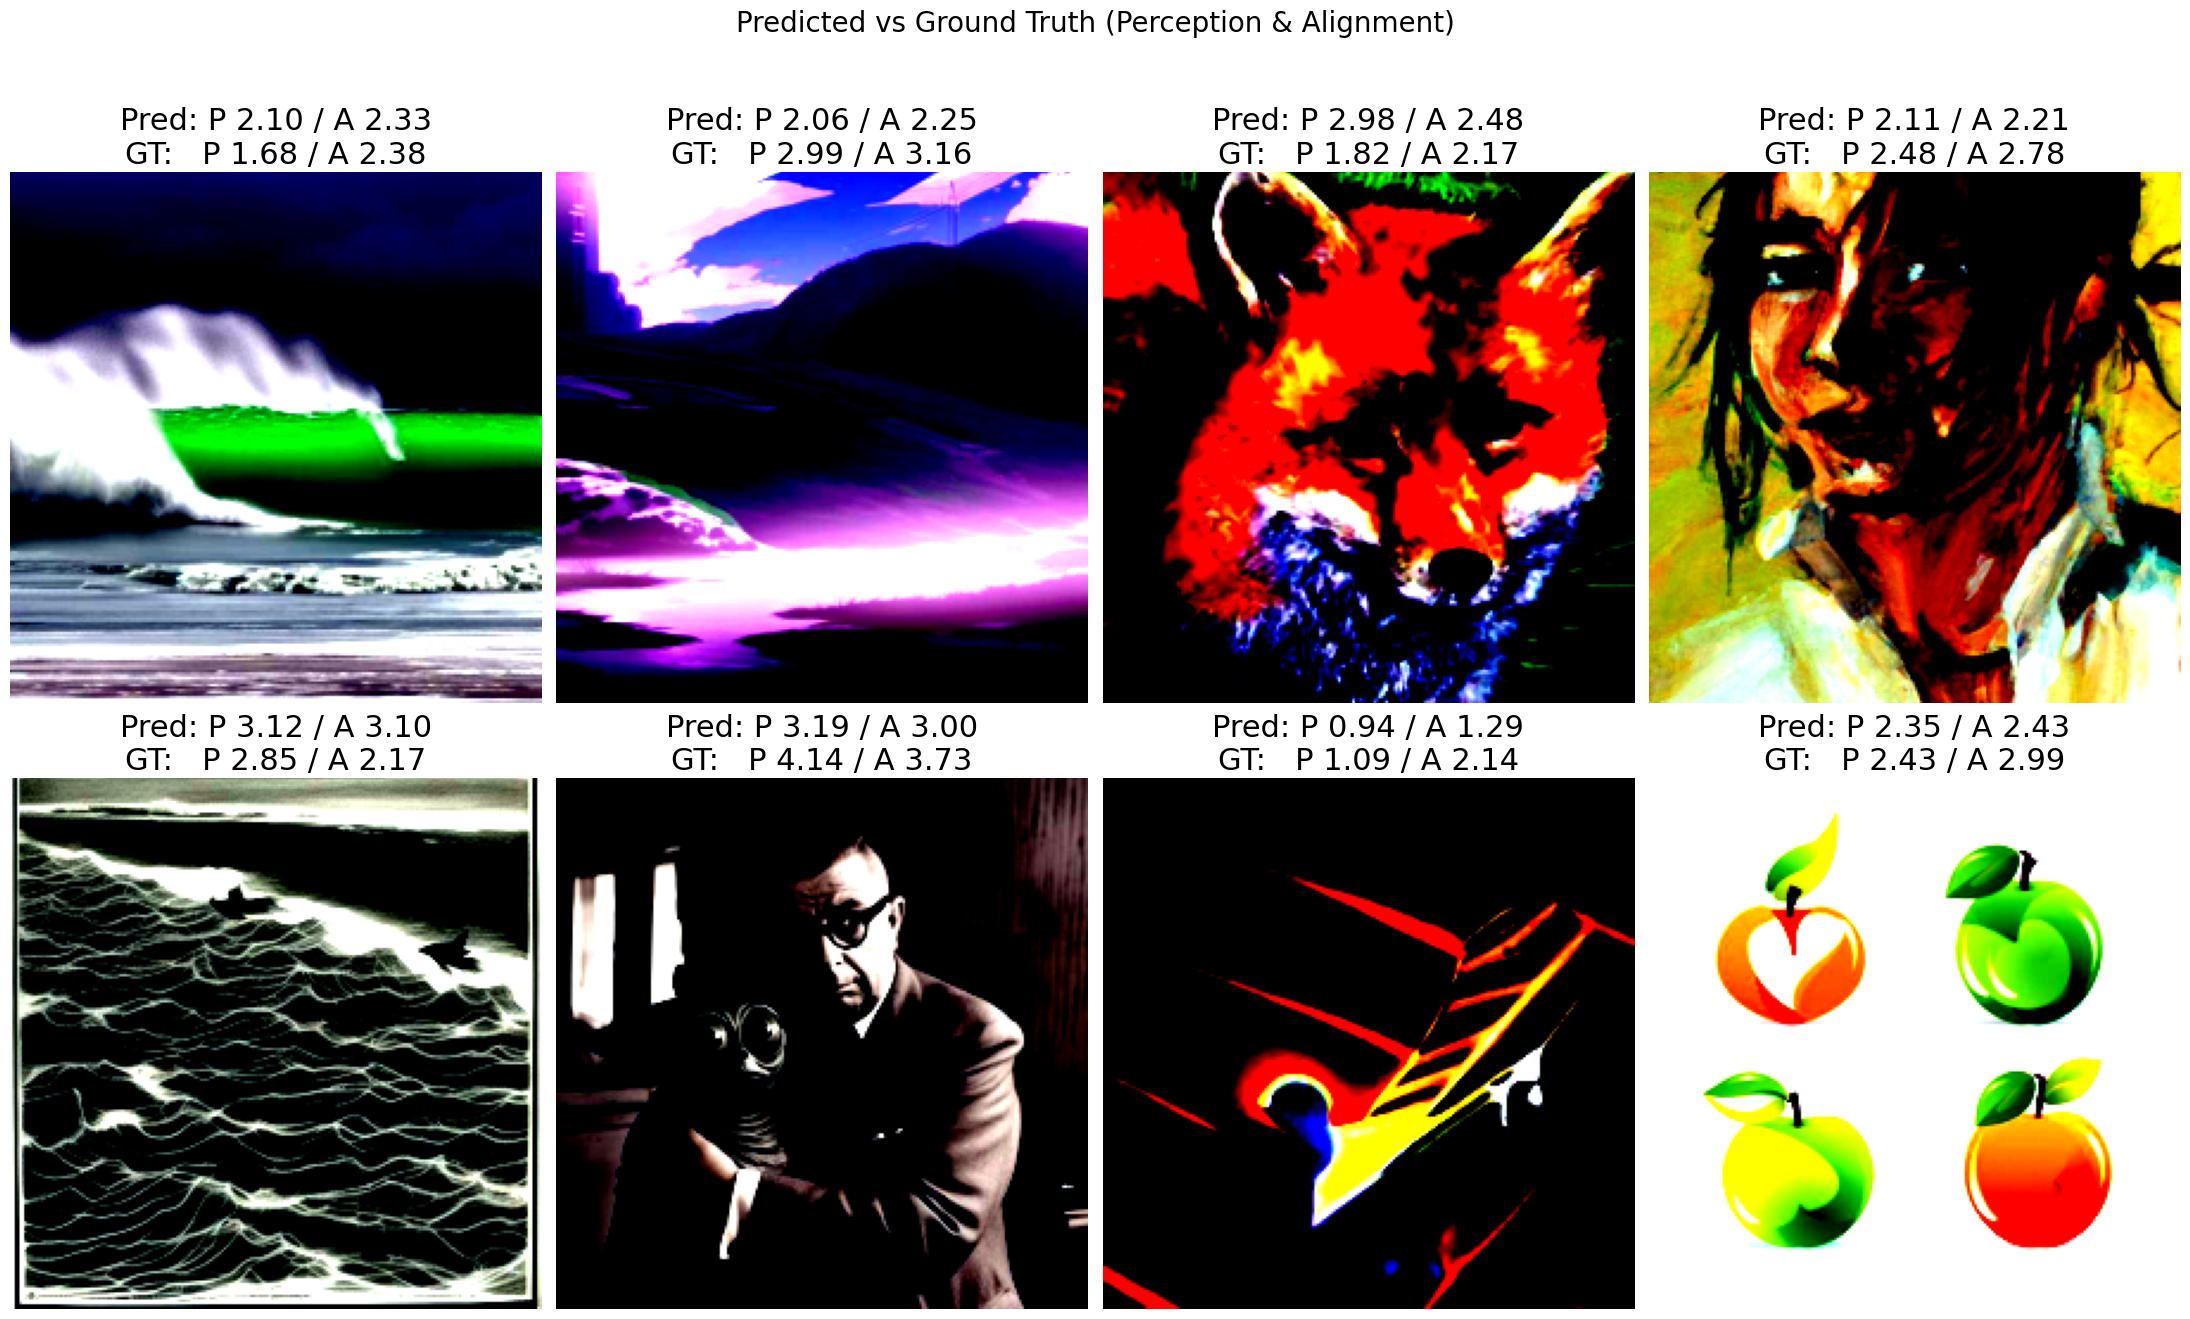

In [53]:
import torch
import matplotlib.pyplot as plt

def predict_8_samples_subplot(model, test_loader, task_prompts):
    model.eval()
    images_to_show = []
    pred_percep = []
    pred_align = []
    gt_percep = []
    gt_align = []
    max_samples = 8

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()
            mos_scores_align = batch["mos_score_align"].to(device).float()

            # Extract patches
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l]).to(device)

            # Get multi-head outputs
            outputs_percep, outputs_align = model(images, patches_tensor, task_prompts, initial_prompts)

            for i in range(images.size(0)):
                if len(images_to_show) >= max_samples:
                    break

                # Prepare image and scores
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                images_to_show.append(img_np)
                pred_percep.append(float(outputs_percep[i]))
                pred_align.append(float(outputs_align[i]))
                gt_percep.append(float(mos_scores[i]))
                gt_align.append(float(mos_scores_align[i]))

            if len(images_to_show) >= max_samples:
                break

    # Plot in a 2x4 grid
    fig, axes = plt.subplots(2, 4, figsize=(22, 14))
    fig.suptitle("Predicted vs Ground Truth (Perception & Alignment)", fontsize=20)

    for i, ax in enumerate(axes.flat):
        if i < len(images_to_show):
            ax.imshow(images_to_show[i])
            ax.set_title(
                f"Pred: P {pred_percep[i]:.2f} / A {pred_align[i]:.2f}\n"
                f"GT:   P {gt_percep[i]:.2f} / A {gt_align[i]:.2f}",
                fontsize=22
            )
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()
predict_8_samples_subplot(model, test_loader, task_prompts)
